In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
from catboost import CatBoostRegressor
from autogluon.tabular import TabularDataset, TabularPredictor
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data
obs_A = pd.read_parquet('../../preprocessing/data/obs_A.parquet')
obs_B = pd.read_parquet('../../preprocessing/data/obs_B.parquet')
obs_C = pd.read_parquet('../../preprocessing/data/obs_C.parquet')
est_A = pd.read_parquet('../../preprocessing/data/est_A.parquet')
est_B = pd.read_parquet('../../preprocessing/data/est_B.parquet')
est_C = pd.read_parquet('../../preprocessing/data/est_C.parquet')
test_A = pd.read_parquet('../../preprocessing/data/test_A.parquet')
test_B = pd.read_parquet('../../preprocessing/data/test_B.parquet')
test_C = pd.read_parquet('../../preprocessing/data/test_C.parquet')

In [3]:
# Set the random seed
np.random.seed(42)

# Concatinate
A = pd.concat([obs_A, est_A])
B = pd.concat([obs_B, est_B])
C = pd.concat([obs_C, est_C])

A.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in A.columns]
B.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in B.columns]
C.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in C.columns]

test_A.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in test_A.columns]
test_B.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in test_B.columns]
test_C.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in test_C.columns]

# Step 1: Filter A to include only months from March to October
A = A[A['date_forecast'].dt.month.isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])]

# Step 2: Identify unique days within May, June, and July
summer_months = A[A['date_forecast'].dt.month.isin([5, 6])]
unique_summer_days = summer_months['date_forecast'].dt.date.unique()

# Step 3: Sample these days for val_A
sampled_days = np.random.choice(unique_summer_days, size=int(len(unique_summer_days) * 0.4), replace=False)
val_A = A[A['date_forecast'].dt.date.isin(sampled_days)]

# Step 4: Define train_A as the remaining data
train_A = A[~A['date_forecast'].dt.date.isin(sampled_days)]

# Prepare your features and target variables
X_train_A = train_A.drop(columns='pv_measurement')
y_train_A = train_A['pv_measurement']
X_val_A = val_A.drop(columns='pv_measurement')
y_val_A = val_A['pv_measurement']

# Repeat for B and C
B = B[B['date_forecast'].dt.month.isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])]
summer_months = B[B['date_forecast'].dt.month.isin([5, 6])]
unique_summer_days = summer_months['date_forecast'].dt.date.unique()
sampled_days = np.random.choice(unique_summer_days, size=int(len(unique_summer_days) * 0.4), replace=False)
val_B = B[B['date_forecast'].dt.date.isin(sampled_days)]
train_B = B[~B['date_forecast'].dt.date.isin(sampled_days)]
X_train_B = train_B.drop(columns='pv_measurement')
y_train_B = train_B['pv_measurement']
X_val_B = val_B.drop(columns='pv_measurement')
y_val_B = val_B['pv_measurement']

C = C[C['date_forecast'].dt.month.isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])]
summer_months = C[C['date_forecast'].dt.month.isin([5, 6])]
unique_summer_days = summer_months['date_forecast'].dt.date.unique()
sampled_days = np.random.choice(unique_summer_days, size=int(len(unique_summer_days) * 0.4), replace=False)
val_C = C[C['date_forecast'].dt.date.isin(sampled_days)]
train_C = C[~C['date_forecast'].dt.date.isin(sampled_days)]
X_train_C = train_C.drop(columns='pv_measurement')
y_train_C = train_C['pv_measurement']
X_val_C = val_C.drop(columns='pv_measurement')
y_val_C = val_C['pv_measurement']

# Drop date_forecast
train_A = train_A.drop(columns=['date_forecast', 'date_forecast_x', 'date_forecast_y'])
train_B = train_B.drop(columns=['date_forecast', 'date_forecast_x', 'date_forecast_y'])
train_C = train_C.drop(columns=['date_forecast', 'date_forecast_x', 'date_forecast_y'])
val_A = val_A.drop(columns=['date_forecast', 'date_forecast_x', 'date_forecast_y'])
val_B = val_B.drop(columns=['date_forecast', 'date_forecast_x', 'date_forecast_y'])
val_C = val_C.drop(columns=['date_forecast', 'date_forecast_x', 'date_forecast_y'])
X_train_A = X_train_A.drop(columns=['date_forecast', 'date_forecast_x', 'date_forecast_y'])
X_train_B = X_train_B.drop(columns=['date_forecast', 'date_forecast_x', 'date_forecast_y'])
X_train_C = X_train_C.drop(columns=['date_forecast', 'date_forecast_x', 'date_forecast_y'])
X_val_A = X_val_A.drop(columns=['date_forecast', 'date_forecast_x', 'date_forecast_y'])
X_val_B = X_val_B.drop(columns=['date_forecast', 'date_forecast_x', 'date_forecast_y'])
X_val_C = X_val_C.drop(columns=['date_forecast', 'date_forecast_x', 'date_forecast_y'])
test_A = test_A.drop(columns=['date_forecast'])
test_B = test_B.drop(columns=['date_forecast'])
test_C = test_C.drop(columns=['date_forecast'])

In [4]:
print(test_A.shape)
print(train_A.shape)
# print(X_train_A['month'].describe())
# print(X_val_A['month'].describe())

(720, 85)
(32069, 86)


In [5]:
train_lgbm_A = lgb.Dataset(X_train_A, label=y_train_A)
val_lgbm_A = lgb.Dataset(X_val_A, label=y_val_A, reference=train_lgbm_A)

train_lgbm_B = lgb.Dataset(X_train_B, label=y_train_B)
val_lgbm_B = lgb.Dataset(X_val_B, label=y_val_B, reference=train_lgbm_B)

train_lgbm_C = lgb.Dataset(X_train_C, label=y_train_C)
val_lgbm_C = lgb.Dataset(X_val_C, label=y_val_C, reference=train_lgbm_C)

train_auto_A = TabularDataset(train_A)
val_auto_A = TabularDataset(val_A)

train_auto_B = TabularDataset(train_B)
val_auto_B = TabularDataset(val_B)

train_auto_C = TabularDataset(train_C)
val_auto_C = TabularDataset(val_C)

auto_label = 'pv_measurement'

# Set the parameters for the LGBM models
params = {
    'boosting_type': 'dart',
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 100,
    'learning_rate': 0.05,
    'verbose': 1
}

# Set the parameters for the XGBoost models
parameters_A = {
    'colsample_bytree': 0.8, 
    'gamma': 0.4, 
    'learning_rate': 0.012, 
    'max_depth': 15, 
    'min_child_weight': 10, 
    'n_estimators': 600, 
    'reg_alpha': 0.8, 
    'reg_lambda': 0.8, 
    'subsample': 0.912,
    'random_state': 0, 
    'booster': 'gbtree',
    'n_jobs': -1,
    'eval_set': [(X_train_A, y_train_A), (X_val_A, y_val_A)],
    'num_parallel_tree': 2
}

parameters_B = {
    'colsample_bytree': 0.8, 
    'gamma': 0.8, 
    'learning_rate': 0.008, 
    'max_depth': 15, 
    'min_child_weight': 10, 
    'n_estimators': 600, 
    'reg_alpha': 1, 
    'reg_lambda': 3, 
    'subsample': 0.912,
    'random_state': 0, 
    'booster': 'gbtree',
    'n_jobs': -1,
    'eval_set': [(X_train_B, y_train_B), (X_val_B, y_val_B)]
}

parameters_C = {
    'colsample_bytree': 0.8, 
    'gamma': 0.8, 
    'learning_rate': 0.008, 
    'max_depth': 15, 
    'min_child_weight': 10, 
    'n_estimators': 600, 
    'reg_alpha': 1, 
    'reg_lambda': 3, 
    'subsample': 0.912,
    'random_state': 0, 
    'booster': 'gbtree',
    'n_jobs': -1,
    'eval_set': [(X_train_C, y_train_C), (X_val_C, y_val_C)]
}

xgb_A = xgb.XGBRegressor(**parameters_A)
xgb_B = xgb.XGBRegressor(**parameters_B)
xgb_C = xgb.XGBRegressor(**parameters_C)

cat_A = CatBoostRegressor(
    iterations=5000,         # The number of trees to build
    #learning_rate=0.09,     # The learning rate
    #depth=10,               # Depth of the tree
    loss_function='MAE',     # Loss function to be optimized. RMSE is common for regression.
    eval_metric='MAE',       # Evaluation metric for the validation set
    #random_seed=42,         # Seed for reproducibility
    #verbose=100             # Frequency of logging the training process
)

cat_B = CatBoostRegressor(
    iterations=5000,
    #learning_rate=0.09,
    #depth=10,
    loss_function='MAE',
    eval_metric='MAE',
    #random_seed=42,
    #verbose=100
)

cat_C = CatBoostRegressor(
    iterations=5000,
    #learning_rate=0.09,
    #depth=10,
    loss_function='MAE',
    eval_metric='MAE',
    #random_seed=42,
    #verbose=100
)


In [6]:
# Train the LGBM models

lgbm_A = lgb.train(params,
                train_lgbm_A,
                num_boost_round=1000,
                valid_sets=[val_lgbm_A],
                early_stopping_rounds=50,
                verbose_eval=50)

lgbm_B = lgb.train(params,
                train_lgbm_B,
                num_boost_round=1000,
                valid_sets=[val_lgbm_B],
                early_stopping_rounds=50,
                verbose_eval=50)

lgbm_C = lgb.train(params,
                train_lgbm_C,
                num_boost_round=1000,
                valid_sets=[val_lgbm_C],
                early_stopping_rounds=50,
                verbose_eval=50)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14985
[LightGBM] [Info] Number of data points in the train set: 32069, number of used features: 82
[LightGBM] [Info] Start training from score 587.731605
[50]	valid_0's l1: 480.375
[100]	valid_0's l1: 438.643
[150]	valid_0's l1: 412.307
[200]	valid_0's l1: 377.705
[250]	valid_0's l1: 364.579
[300]	valid_0's l1: 358.151
[350]	valid_0's l1: 356.669
[400]	valid_0's l1: 346.976
[450]	valid_0's l1: 345.029
[500]	valid_0's l1: 344.989
[550]	valid_0's l1: 345.697
[600]	valid_0's l1: 350.884
[650]	valid_0's l1: 345.289
[700]	valid_0's l1: 344.429
[750]	valid_0's l1: 343.747
[800]	valid_0's l1: 346.277
[850]	valid_0's l1: 344.717
[900]	valid_0's l1: 344.262
[950]	valid_0's l1: 345.372
[1000]	valid_0's l1: 345.409
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.0

In [7]:
# Train the XGBoost models
xgb_A.fit(
    X=X_train_A, y=y_train_A,
    eval_set=[(X_train_A, y_train_A), (X_val_A, y_val_A)],
    eval_metric='mae',
    verbose=False
)

xgb_B.fit(
    X=X_train_B, y=y_train_B,
    eval_set=[(X_train_B, y_train_B), (X_val_B, y_val_B)],
    eval_metric='mae',
    verbose=False
)

xgb_C.fit(
    X=X_train_C, y=y_train_C,
    eval_set=[(X_train_C, y_train_C), (X_val_C, y_val_C)],
    eval_metric='mae',
    verbose=False
)

[01:29:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "eval_set" } are not used.

[01:31:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "eval_set" } are not used.

[01:32:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "eval_set" } are not used.



XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             eval_set=[(      diffuse_radW  direct_radW  clear_sky_radW  diffuse_rad_1hJ  \
0       271.899994   369.000000     1684.900024    242276.906250   
1       306.500000   417.399994     2032.500000    279501.312500...
             feature_types=None, gamma=0.8, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.008, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=10, missing=nan,
             monotone_constraints=None, n_estimators=600, n_jobs=-1,
             num_parallel_tree=None, predictor=None, ...)

In [8]:
# Train the CatBoost models
cat_A.fit(
    X_train_A, y_train_A,
    eval_set=(X_val_A, y_val_A),
    use_best_model=True
)

cat_B.fit(
    X_train_B, y_train_B,
    eval_set=(X_val_B, y_val_B),
    use_best_model=True
)

cat_C.fit(
    X_train_C, y_train_C,
    eval_set=(X_val_C, y_val_C),
    use_best_model=True
)

0:	learn: 573.5063437	test: 1283.4656058	best: 1283.4656058 (0)	total: 66.1ms	remaining: 5m 30s
1:	learn: 562.0841662	test: 1261.0148797	best: 1261.0148797 (1)	total: 78.5ms	remaining: 3m 16s
2:	learn: 547.7945747	test: 1229.0452148	best: 1229.0452148 (2)	total: 85.3ms	remaining: 2m 22s
3:	learn: 535.7232783	test: 1205.8921673	best: 1205.8921673 (3)	total: 92.3ms	remaining: 1m 55s
4:	learn: 523.4185134	test: 1180.7471260	best: 1180.7471260 (4)	total: 99.6ms	remaining: 1m 39s
5:	learn: 513.5300540	test: 1162.4609316	best: 1162.4609316 (5)	total: 107ms	remaining: 1m 29s
6:	learn: 504.1811839	test: 1144.7271436	best: 1144.7271436 (6)	total: 114ms	remaining: 1m 21s
7:	learn: 495.8774030	test: 1129.4411050	best: 1129.4411050 (7)	total: 122ms	remaining: 1m 15s
8:	learn: 486.2278698	test: 1110.0318416	best: 1110.0318416 (8)	total: 129ms	remaining: 1m 11s
9:	learn: 474.7738373	test: 1085.0359099	best: 1085.0359099 (9)	total: 136ms	remaining: 1m 7s
10:	learn: 464.6028584	test: 1063.1716407	best

In [9]:
auto_A = TabularPredictor(label=auto_label, eval_metric='mean_absolute_error', problem_type='regression').fit(train_auto_A, 
                                                                                   presets='good_quality', 
                                                                                   tuning_data=val_auto_A, 
                                                                                   use_bag_holdout=True, 
                                                                                   ag_args_ensemble={'fold_fitting_strategy': 'sequential_local'})
auto_A.plot_ensemble_model()

No path specified. Models will be saved in: "AutogluonModels/ag-20231112_003513/"
Presets specified: ['good_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231112_003513/"
AutoGluon Version:  0.8.2
Python Version:     3.8.18
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 21.6.0: Wed Aug 10 14:28:23 PDT 2022; root:xnu-8020.141.5~2/RELEASE_ARM64_T6000
Disk Space Avail:   40.18 GB / 494.38 GB (8.1%)
Train Data Rows:    32069
Train Data Columns: 85
Tuning Data Rows:    2016
Tuning Data Columns: 85
Label Column: pv_measurement
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5642.9 MB
	Train Data (Original)  Memory Usage: 12.41 MB (0.2% of available memory)
	Inferring data type of each feature based on c

[1000]	valid_set's l1: 162.83
[2000]	valid_set's l1: 157.814
[3000]	valid_set's l1: 155.522
[4000]	valid_set's l1: 154.025
[5000]	valid_set's l1: 152.96
[6000]	valid_set's l1: 152.338
[7000]	valid_set's l1: 151.889
[8000]	valid_set's l1: 151.536
[9000]	valid_set's l1: 151.286
[10000]	valid_set's l1: 151.054
[1000]	valid_set's l1: 155.655
[2000]	valid_set's l1: 150.164
[3000]	valid_set's l1: 147.386
[4000]	valid_set's l1: 145.814
[5000]	valid_set's l1: 144.904
[6000]	valid_set's l1: 144.384
[7000]	valid_set's l1: 144.062
[8000]	valid_set's l1: 143.86
[9000]	valid_set's l1: 143.589
[10000]	valid_set's l1: 143.489
[1000]	valid_set's l1: 154.142
[2000]	valid_set's l1: 148.43
[3000]	valid_set's l1: 145.778
[4000]	valid_set's l1: 144.447
[5000]	valid_set's l1: 143.409
[6000]	valid_set's l1: 143.006
[7000]	valid_set's l1: 142.566
[8000]	valid_set's l1: 142.27
[9000]	valid_set's l1: 142.053
[10000]	valid_set's l1: 141.888
[1000]	valid_set's l1: 152.194
[2000]	valid_set's l1: 146.304
[3000]	val

	-340.2718	 = Validation score   (-mean_absolute_error)
	2028.52s	 = Training   runtime
	4.87s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 160.922
[2000]	valid_set's l1: 158.3
[3000]	valid_set's l1: 157.196
[4000]	valid_set's l1: 156.589
[5000]	valid_set's l1: 156.258
[6000]	valid_set's l1: 156.051
[7000]	valid_set's l1: 155.946
[8000]	valid_set's l1: 155.868
[9000]	valid_set's l1: 155.831
[10000]	valid_set's l1: 155.802
[1000]	valid_set's l1: 158.428
[2000]	valid_set's l1: 155.85
[3000]	valid_set's l1: 154.996
[4000]	valid_set's l1: 154.529
[5000]	valid_set's l1: 154.273
[6000]	valid_set's l1: 154.087
[7000]	valid_set's l1: 153.936
[8000]	valid_set's l1: 153.865
[9000]	valid_set's l1: 153.811
[10000]	valid_set's l1: 153.778
[1000]	valid_set's l1: 160.598
[2000]	valid_set's l1: 157.582
[3000]	valid_set's l1: 156.697
[4000]	valid_set's l1: 156.232
[5000]	valid_set's l1: 155.981
[6000]	valid_set's l1: 155.842
[7000]	valid_set's l1: 155.696
[8000]	valid_set's l1: 155.618
[9000]	valid_set's l1: 155.564
[10000]	valid_set's l1: 155.545
[1000]	valid_set's l1: 150.287
[2000]	valid_set's l1: 147.523
[3000]	v

	-340.4697	 = Validation score   (-mean_absolute_error)
	650.64s	 = Training   runtime
	7.88s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ...
	-342.1111	 = Validation score   (-mean_absolute_error)
	71.37s	 = Training   runtime
	0.69s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-341.7772	 = Validation score   (-mean_absolute_error)
	978.69s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ...
	-338.1895	 = Validation score   (-mean_absolute_error)
	13.25s	 = Training   runtime
	0.84s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-341.2049	 = Validation score   (-mean_absolute_error)
	127.1s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: XGBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with S

[1000]	valid_set's l1: 155.649
[2000]	valid_set's l1: 154.552
[3000]	valid_set's l1: 154.336
[4000]	valid_set's l1: 154.271
[5000]	valid_set's l1: 154.25
[6000]	valid_set's l1: 154.243
[7000]	valid_set's l1: 154.241
[8000]	valid_set's l1: 154.24
[9000]	valid_set's l1: 154.239
[10000]	valid_set's l1: 154.239
[1000]	valid_set's l1: 152.039
[2000]	valid_set's l1: 151.05
[3000]	valid_set's l1: 150.813
[4000]	valid_set's l1: 150.744
[5000]	valid_set's l1: 150.718
[6000]	valid_set's l1: 150.71
[7000]	valid_set's l1: 150.707
[8000]	valid_set's l1: 150.706
[9000]	valid_set's l1: 150.706
[10000]	valid_set's l1: 150.706
[1000]	valid_set's l1: 153.523
[2000]	valid_set's l1: 152.597
[3000]	valid_set's l1: 152.399
[4000]	valid_set's l1: 152.347
[5000]	valid_set's l1: 152.329
[6000]	valid_set's l1: 152.325
[7000]	valid_set's l1: 152.323
[8000]	valid_set's l1: 152.322
[9000]	valid_set's l1: 152.322
[10000]	valid_set's l1: 152.322
[1000]	valid_set's l1: 145.042
[2000]	valid_set's l1: 143.675
[3000]	va

	-335.8239	 = Validation score   (-mean_absolute_error)
	4532.43s	 = Training   runtime
	13.31s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-319.6064	 = Validation score   (-mean_absolute_error)
	0.16s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 9 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-334.3441	 = Validation score   (-mean_absolute_error)
	38.15s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-332.5352	 = Validation score   (-mean_absolute_error)
	22.54s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ...
	-332.4874	 = Validation score   (-mean_absolute_error)
	87.26s	 = Training   runtime
	0.71s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8

'AutogluonModels/ag-20231112_003513/ensemble_model.png'

In [10]:
auto_B = TabularPredictor(label=auto_label, eval_metric='mean_absolute_error', problem_type='regression').fit(train_auto_B,
                                                                                      presets='good_quality',
                                                                                      tuning_data=val_auto_B,
                                                                                      use_bag_holdout=True,
                                                                                      ag_args_ensemble={'fold_fitting_strategy': 'sequential_local'})
auto_B.plot_ensemble_model()

No path specified. Models will be saved in: "AutogluonModels/ag-20231112_042107/"
Presets specified: ['good_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231112_042107/"
AutoGluon Version:  0.8.2
Python Version:     3.8.18
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 21.6.0: Wed Aug 10 14:28:23 PDT 2022; root:xnu-8020.141.5~2/RELEASE_ARM64_T6000
Disk Space Avail:   36.86 GB / 494.38 GB (7.5%)
Train Data Rows:    25818
Train Data Columns: 85
Tuning Data Rows:    1720
Tuning Data Columns: 85
Label Column: pv_measurement
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5214.53 MB
	Train Data (Original)  Memory Usage: 10.02 MB (0.2% of available memory)
	Inferring data type of each feature based on 

[1000]	valid_set's l1: 20.8728
[2000]	valid_set's l1: 20.0603
[3000]	valid_set's l1: 19.6736
[4000]	valid_set's l1: 19.4315
[5000]	valid_set's l1: 19.259
[6000]	valid_set's l1: 19.1485
[7000]	valid_set's l1: 19.0617
[8000]	valid_set's l1: 19.0045
[9000]	valid_set's l1: 18.9636
[10000]	valid_set's l1: 18.9233
[1000]	valid_set's l1: 22.0908
[2000]	valid_set's l1: 21.3446
[3000]	valid_set's l1: 20.9175
[4000]	valid_set's l1: 20.6935
[5000]	valid_set's l1: 20.5453
[6000]	valid_set's l1: 20.4464
[7000]	valid_set's l1: 20.3689
[8000]	valid_set's l1: 20.3142
[9000]	valid_set's l1: 20.2752
[10000]	valid_set's l1: 20.2455
[1000]	valid_set's l1: 20.9116
[2000]	valid_set's l1: 20.0848
[3000]	valid_set's l1: 19.6824
[4000]	valid_set's l1: 19.4701
[5000]	valid_set's l1: 19.3475
[6000]	valid_set's l1: 19.2445
[7000]	valid_set's l1: 19.1827
[8000]	valid_set's l1: 19.1416
[9000]	valid_set's l1: 19.1153
[10000]	valid_set's l1: 19.0844
[1000]	valid_set's l1: 23.1222
[2000]	valid_set's l1: 22.0593
[3000]

	-79.2582	 = Validation score   (-mean_absolute_error)
	663.83s	 = Training   runtime
	4.53s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 20.9868
[2000]	valid_set's l1: 20.5981
[3000]	valid_set's l1: 20.4381
[4000]	valid_set's l1: 20.3656
[5000]	valid_set's l1: 20.3463
[6000]	valid_set's l1: 20.3375
[7000]	valid_set's l1: 20.3333
[8000]	valid_set's l1: 20.3283
[9000]	valid_set's l1: 20.3235
[10000]	valid_set's l1: 20.3213
[1000]	valid_set's l1: 22.1387
[2000]	valid_set's l1: 21.6496
[3000]	valid_set's l1: 21.487
[4000]	valid_set's l1: 21.4055
[5000]	valid_set's l1: 21.357
[6000]	valid_set's l1: 21.3282
[7000]	valid_set's l1: 21.3193
[8000]	valid_set's l1: 21.3122
[9000]	valid_set's l1: 21.3075
[10000]	valid_set's l1: 21.3057
[1000]	valid_set's l1: 20.2432
[2000]	valid_set's l1: 19.8824
[3000]	valid_set's l1: 19.7845
[4000]	valid_set's l1: 19.7031
[5000]	valid_set's l1: 19.6789
[6000]	valid_set's l1: 19.67
[7000]	valid_set's l1: 19.6607
[8000]	valid_set's l1: 19.6568
[9000]	valid_set's l1: 19.6533
[10000]	valid_set's l1: 19.6525
[1000]	valid_set's l1: 23.0443
[2000]	valid_set's l1: 22.5646
[3000]	va

	-77.9077	 = Validation score   (-mean_absolute_error)
	706.62s	 = Training   runtime
	5.67s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ...
	-78.0104	 = Validation score   (-mean_absolute_error)
	53.85s	 = Training   runtime
	0.64s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-77.7125	 = Validation score   (-mean_absolute_error)
	857.31s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ...
	-77.5997	 = Validation score   (-mean_absolute_error)
	9.15s	 = Training   runtime
	0.75s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-77.6827	 = Validation score   (-mean_absolute_error)
	100.62s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: XGBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with Sequent

[1000]	valid_set's l1: 19.7514
[2000]	valid_set's l1: 19.5897
[3000]	valid_set's l1: 19.5621
[4000]	valid_set's l1: 19.5552
[5000]	valid_set's l1: 19.5535
[6000]	valid_set's l1: 19.5529
[7000]	valid_set's l1: 19.5527
[8000]	valid_set's l1: 19.5526
[9000]	valid_set's l1: 19.5526
[10000]	valid_set's l1: 19.5526
[1000]	valid_set's l1: 21.4465
[2000]	valid_set's l1: 21.2783
[3000]	valid_set's l1: 21.2469
[4000]	valid_set's l1: 21.2405
[5000]	valid_set's l1: 21.2378
[6000]	valid_set's l1: 21.2371
[7000]	valid_set's l1: 21.2368
[8000]	valid_set's l1: 21.2367
[9000]	valid_set's l1: 21.2367
[10000]	valid_set's l1: 21.2366
[1000]	valid_set's l1: 19.0294
[2000]	valid_set's l1: 18.9135
[3000]	valid_set's l1: 18.8994
[4000]	valid_set's l1: 18.8938
[5000]	valid_set's l1: 18.8922
[6000]	valid_set's l1: 18.8918
[7000]	valid_set's l1: 18.8915
[8000]	valid_set's l1: 18.8914
[9000]	valid_set's l1: 18.8914
[10000]	valid_set's l1: 18.8914
[1000]	valid_set's l1: 22.3007
[2000]	valid_set's l1: 22.1569
[3000

	-76.7423	 = Validation score   (-mean_absolute_error)
	2520.35s	 = Training   runtime
	11.3s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-75.2145	 = Validation score   (-mean_absolute_error)
	0.16s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 9 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 19.1355
[1000]	valid_set's l1: 20.3419


	-77.6193	 = Validation score   (-mean_absolute_error)
	52.53s	 = Training   runtime
	0.17s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-77.8621	 = Validation score   (-mean_absolute_error)
	23.9s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ...
	-77.9445	 = Validation score   (-mean_absolute_error)
	67.98s	 = Training   runtime
	0.68s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-76.5756	 = Validation score   (-mean_absolute_error)
	31.11s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L2 ...
	-77.5907	 = Validation score   (-mean_absolute_error)
	9.88s	 = Training   runtime
	0.85s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with Sequentia

'AutogluonModels/ag-20231112_042107/ensemble_model.png'

In [11]:
auto_C = TabularPredictor(label=auto_label, eval_metric='mean_absolute_error', problem_type='regression').fit(train_auto_C,
                                                                                        presets='good_quality',
                                                                                        tuning_data=val_auto_C,
                                                                                        use_bag_holdout=True,
                                                                                        ag_args_ensemble={'fold_fitting_strategy': 'sequential_local'})
auto_C.plot_ensemble_model()

No path specified. Models will be saved in: "AutogluonModels/ag-20231112_071515/"
Presets specified: ['good_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231112_071515/"
AutoGluon Version:  0.8.2
Python Version:     3.8.18
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 21.6.0: Wed Aug 10 14:28:23 PDT 2022; root:xnu-8020.141.5~2/RELEASE_ARM64_T6000
Disk Space Avail:   33.75 GB / 494.38 GB (6.8%)
Train Data Rows:    21002
Train Data Columns: 85
Tuning Data Rows:    1152
Tuning Data Columns: 85
Label Column: pv_measurement
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5104.75 MB
	Train Data (Original)  Memory Usage: 8.06 MB (0.2% of available memory)
	Inferring data type of each feature based on c

[1000]	valid_set's l1: 19.9892
[2000]	valid_set's l1: 19.3198
[3000]	valid_set's l1: 19.0151
[4000]	valid_set's l1: 18.8778
[5000]	valid_set's l1: 18.817
[6000]	valid_set's l1: 18.7702
[7000]	valid_set's l1: 18.7336
[8000]	valid_set's l1: 18.713
[9000]	valid_set's l1: 18.6974
[10000]	valid_set's l1: 18.6888
[1000]	valid_set's l1: 19.1029
[2000]	valid_set's l1: 18.6002
[3000]	valid_set's l1: 18.3858
[4000]	valid_set's l1: 18.2657
[5000]	valid_set's l1: 18.1642
[6000]	valid_set's l1: 18.1061
[7000]	valid_set's l1: 18.085
[8000]	valid_set's l1: 18.0667
[9000]	valid_set's l1: 18.0491
[10000]	valid_set's l1: 18.036
[1000]	valid_set's l1: 19.9738
[2000]	valid_set's l1: 19.3368
[3000]	valid_set's l1: 19.1474
[4000]	valid_set's l1: 19.0475
[5000]	valid_set's l1: 18.9681
[6000]	valid_set's l1: 18.9277
[7000]	valid_set's l1: 18.8929
[8000]	valid_set's l1: 18.8714
[9000]	valid_set's l1: 18.8474
[10000]	valid_set's l1: 18.8367
[1000]	valid_set's l1: 19.0394
[2000]	valid_set's l1: 18.3343
[3000]	va

	-54.6459	 = Validation score   (-mean_absolute_error)
	651.96s	 = Training   runtime
	3.66s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 19.7446
[2000]	valid_set's l1: 19.4692
[3000]	valid_set's l1: 19.3792
[4000]	valid_set's l1: 19.3492
[5000]	valid_set's l1: 19.3302
[6000]	valid_set's l1: 19.3245
[7000]	valid_set's l1: 19.3203
[8000]	valid_set's l1: 19.3175
[9000]	valid_set's l1: 19.3162
[10000]	valid_set's l1: 19.3149
[1000]	valid_set's l1: 19.2721
[2000]	valid_set's l1: 18.9685
[3000]	valid_set's l1: 18.8819
[4000]	valid_set's l1: 18.8457
[5000]	valid_set's l1: 18.8248
[6000]	valid_set's l1: 18.8136
[7000]	valid_set's l1: 18.8113
[8000]	valid_set's l1: 18.8088
[9000]	valid_set's l1: 18.8074
[10000]	valid_set's l1: 18.8066
[1000]	valid_set's l1: 20.0573
[2000]	valid_set's l1: 19.7729
[3000]	valid_set's l1: 19.6985
[4000]	valid_set's l1: 19.6729
[5000]	valid_set's l1: 19.6601
[6000]	valid_set's l1: 19.654
[7000]	valid_set's l1: 19.6491
[8000]	valid_set's l1: 19.646
[9000]	valid_set's l1: 19.6455
[10000]	valid_set's l1: 19.6447
[1000]	valid_set's l1: 19.0296
[2000]	valid_set's l1: 18.6999
[3000]	

	-53.4996	 = Validation score   (-mean_absolute_error)
	709.62s	 = Training   runtime
	5.37s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ...
	-53.5645	 = Validation score   (-mean_absolute_error)
	41.83s	 = Training   runtime
	0.55s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-53.2952	 = Validation score   (-mean_absolute_error)
	874.11s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ...
	-52.8675	 = Validation score   (-mean_absolute_error)
	7.17s	 = Training   runtime
	0.67s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-51.9282	 = Validation score   (-mean_absolute_error)
	83.43s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: XGBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with Sequent

[1000]	valid_set's l1: 19.2654
[2000]	valid_set's l1: 19.1967
[3000]	valid_set's l1: 19.1844
[4000]	valid_set's l1: 19.1822
[5000]	valid_set's l1: 19.1818
[6000]	valid_set's l1: 19.1817
[7000]	valid_set's l1: 19.1816
[8000]	valid_set's l1: 19.1816
[9000]	valid_set's l1: 19.1816
[10000]	valid_set's l1: 19.1816
[1000]	valid_set's l1: 18.7978
[2000]	valid_set's l1: 18.7244
[3000]	valid_set's l1: 18.7104
[4000]	valid_set's l1: 18.7083
[5000]	valid_set's l1: 18.7079
[6000]	valid_set's l1: 18.7077
[7000]	valid_set's l1: 18.7077
[8000]	valid_set's l1: 18.7076
[9000]	valid_set's l1: 18.7076
[10000]	valid_set's l1: 18.7076
[1000]	valid_set's l1: 19.5416
[2000]	valid_set's l1: 19.4862
[3000]	valid_set's l1: 19.4766
[4000]	valid_set's l1: 19.474
[5000]	valid_set's l1: 19.4736
[6000]	valid_set's l1: 19.4735
[7000]	valid_set's l1: 19.4735
[8000]	valid_set's l1: 19.4735
[9000]	valid_set's l1: 19.4735
[10000]	valid_set's l1: 19.4735
[1000]	valid_set's l1: 19.001
[2000]	valid_set's l1: 18.9324
[3000]	

	-53.13	 = Validation score   (-mean_absolute_error)
	3392.81s	 = Training   runtime
	9.65s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-50.9138	 = Validation score   (-mean_absolute_error)
	0.07s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 9 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-53.6184	 = Validation score   (-mean_absolute_error)
	43.43s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-53.3909	 = Validation score   (-mean_absolute_error)
	29.29s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ...
	-53.3428	 = Validation score   (-mean_absolute_error)
	29.34s	 = Training   runtime
	0.44s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitt

'AutogluonModels/ag-20231112_071515/ensemble_model.png'

In [12]:
# Loading in autogluon models
# auto_A = TabularPredictor(label=auto_label, eval_metric='mean_absolute_error').load('./AutogluonModels/ag-20231111_193535/')
# auto_B = TabularPredictor(label=auto_label, eval_metric='mean_absolute_error').load('./AutogluonModels/ag-20231111_193648/')
# auto_C = TabularPredictor(label=auto_label, eval_metric='mean_absolute_error').load('./AutogluonModels/ag-20231111_193745/')

In [13]:
auto_A.leaderboard(val_auto_A, silent=True)
# all_models = auto_A.get_model_names()
# print("All Models:", all_models)

# NeuralNetTorch

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMLarge_BAG_L1_FULL,-0.027053,NaN,0.960124,NaN,2649.841489,0.960124,NaN,2649.841489,1,True,29
1,XGBoost_BAG_L1_FULL,-0.058642,NaN,0.422189,NaN,104.856770,0.422189,NaN,104.856770,1,True,27
2,LightGBM_BAG_L1_FULL,-3.631967,NaN,0.357460,NaN,77.950818,0.357460,NaN,77.950818,1,True,22
3,LightGBMXT_BAG_L1_FULL,-19.535367,NaN,0.355828,NaN,83.039474,0.355828,NaN,83.039474,1,True,21
4,CatBoost_BAG_L1_FULL,-42.042938,NaN,0.016307,NaN,98.853487,0.016307,NaN,98.853487,1,True,24
5,ExtraTreesMSE_BAG_L2_FULL,-60.695686,NaN,2.496789,NaN,3144.144134,0.108775,NaN,6.696921,2,True,35
6,WeightedEnsemble_L3_FULL,-61.082730,NaN,2.530684,NaN,3205.545568,0.001887,NaN,0.149838,3,True,40
7,CatBoost_BAG_L2_FULL,-65.432285,NaN,2.392095,NaN,3138.637230,0.004081,NaN,1.190018,2,True,34
8,RandomForestMSE_BAG_L2_FULL,-65.774964,NaN,2.477372,NaN,3184.842249,0.089358,NaN,47.395037,2,True,33
9,LightGBM_BAG_L2_FULL,-66.795928,NaN,2.400050,NaN,3139.364493,0.012036,NaN,1.917281,2,True,32


In [14]:
# Predictions
y_pred_lgbm_A = lgbm_A.predict(X_val_A, num_iteration=lgbm_A.best_iteration)
y_pred_lgbm_B = lgbm_B.predict(X_val_B, num_iteration=lgbm_B.best_iteration)
y_pred_lgbm_C = lgbm_C.predict(X_val_C, num_iteration=lgbm_C.best_iteration)

y_pred_xgb_A = xgb_A.predict(X_val_A)
y_pred_xgb_B = xgb_B.predict(X_val_B)
y_pred_xgb_C = xgb_C.predict(X_val_C)

y_pred_cat_A = cat_A.predict(X_val_A)
y_pred_cat_B = cat_B.predict(X_val_B)
y_pred_cat_C = cat_C.predict(X_val_C)

y_pred_auto_A = auto_A.predict(val_auto_A) #, model='NeuralNetTorch'
y_pred_auto_B = auto_B.predict(val_auto_B) #, model='NeuralNetTorch'
y_pred_auto_C = auto_C.predict(val_auto_C) #, model='NeuralNetTorch'

y_pred_A = (y_pred_cat_A + y_pred_auto_A) / 2
y_pred_B = (y_pred_cat_B + y_pred_auto_B) / 2
y_pred_C = (y_pred_cat_C + y_pred_auto_C) / 2

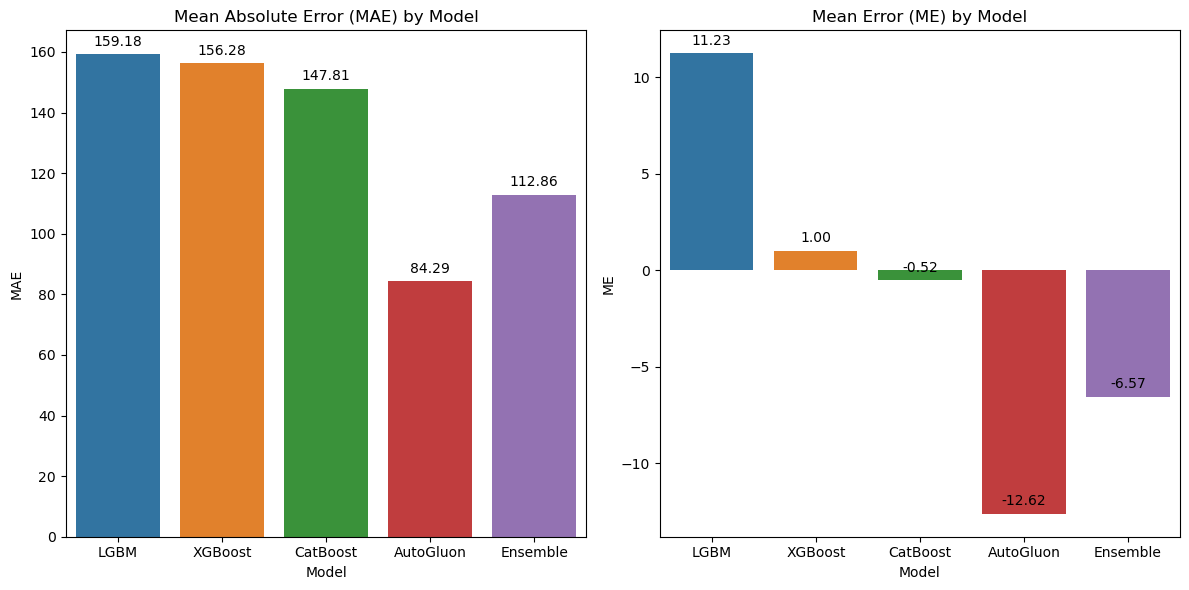

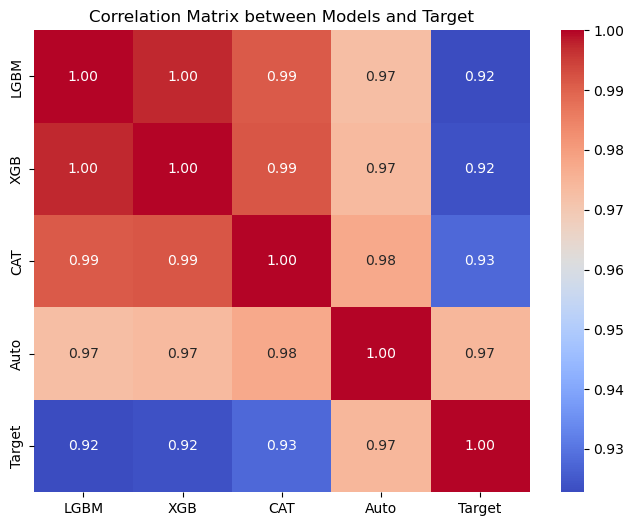

In [15]:
# Evaluate the models
mae_lgbm = (mean_absolute_error(y_val_A, y_pred_lgbm_A) + mean_absolute_error(y_val_B, y_pred_lgbm_B) + mean_absolute_error(y_val_C, y_pred_lgbm_C)) / 3
me_lgbm = (np.mean(y_val_A - y_pred_lgbm_A) + np.mean(y_val_B - y_pred_lgbm_B) + np.mean(y_val_C - y_pred_lgbm_C)) / 3

mae_xgb = (mean_absolute_error(y_val_A, y_pred_xgb_A) + mean_absolute_error(y_val_B, y_pred_xgb_B) + mean_absolute_error(y_val_C, y_pred_xgb_C)) / 3
me_xgb = (np.mean(y_val_A - y_pred_xgb_A) + np.mean(y_val_B - y_pred_xgb_B) + np.mean(y_val_C - y_pred_xgb_C)) / 3

mae_cat = (mean_absolute_error(y_val_A, y_pred_cat_A) + mean_absolute_error(y_val_B, y_pred_cat_B) + mean_absolute_error(y_val_C, y_pred_cat_C)) / 3
me_cat = (np.mean(y_val_A - y_pred_cat_A) + np.mean(y_val_B - y_pred_cat_B) + np.mean(y_val_C - y_pred_cat_C)) / 3

mae_auto = (mean_absolute_error(y_val_A, y_pred_auto_A) + mean_absolute_error(y_val_B, y_pred_auto_B) + mean_absolute_error(y_val_C, y_pred_auto_C)) / 3
me_auto = (np.mean(y_val_A - y_pred_auto_A) + np.mean(y_val_B - y_pred_auto_B) + np.mean(y_val_C - y_pred_auto_C)) / 3

mae_ensemble = (mean_absolute_error(y_val_A, y_pred_A) + mean_absolute_error(y_val_B, y_pred_B) + mean_absolute_error(y_val_C, y_pred_C)) / 3
me_ensemble = (np.mean(y_val_A - y_pred_A) + np.mean(y_val_B - y_pred_B) + np.mean(y_val_C - y_pred_C)) / 3


metric_data = {
    'Model': ['LGBM', 'XGBoost', 'CatBoost', 'AutoGluon', 'Ensemble'],
    'MAE': [mae_lgbm, mae_xgb, mae_cat, mae_auto, mae_ensemble],
    'ME': [me_lgbm, me_xgb, me_cat, me_auto, me_ensemble]
}
df = pd.DataFrame(metric_data)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# MAE Plot
mae_barplot = sns.barplot(x='Model', y='MAE', data=df, ax=ax[0])
ax[0].set_title('Mean Absolute Error (MAE) by Model')
ax[0].set_ylabel('MAE')
ax[0].set_xlabel('Model')

# Annotate MAE values
for p in mae_barplot.patches:
    mae_barplot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

# ME Plot
me_barplot = sns.barplot(x='Model', y='ME', data=df, ax=ax[1])
ax[1].set_title('Mean Error (ME) by Model')
ax[1].set_ylabel('ME')
ax[1].set_xlabel('Model')

# Annotate ME values
for p in me_barplot.patches:
    me_barplot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.tight_layout()
plt.show()


# Correlation between models
predictions = {
    'LGBM': y_pred_lgbm_A,
    'XGB': y_pred_xgb_A,
    'CAT': y_pred_cat_A,
    'Auto': y_pred_auto_A,
    'Target': y_val_A
}

df = pd.DataFrame(predictions)

# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix between Models and Target")
plt.show()

In [19]:
auto_A.leaderboard()

                          model   score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L2 -319.606431      19.435151  6878.317296                0.000325           0.162465            2       True         10
1         NeuralNetTorch_BAG_L1 -324.322822       0.236796   176.851580                0.236796         176.851580            1       True          8
2           WeightedEnsemble_L3 -328.473522      36.075172  9988.459952                0.000326           0.149838            3       True         20
3         NeuralNetTorch_BAG_L2 -331.168419      35.150693  9775.244715                0.292097         125.882462            2       True         18
4          ExtraTreesMSE_BAG_L2 -332.135595      35.853855  9662.876633                0.995259          13.514379            2       True         15
5          LightGBMLarge_BAG_L2 -332.154003      35.025138  9753.215728                0.166542     

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-319.606431,19.435151,6878.317296,0.000325,0.162465,2,True,10
1,NeuralNetTorch_BAG_L1,-324.322822,0.236796,176.851580,0.236796,176.851580,1,True,8
2,WeightedEnsemble_L3,-328.473522,36.075172,9988.459952,0.000326,0.149838,3,True,20
3,NeuralNetTorch_BAG_L2,-331.168419,35.150693,9775.244715,0.292097,125.882462,2,True,18
4,ExtraTreesMSE_BAG_L2,-332.135595,35.853855,9662.876633,0.995259,13.514379,2,True,15
5,LightGBMLarge_BAG_L2,-332.154003,35.025138,9753.215728,0.166542,103.853474,2,True,19
6,RandomForestMSE_BAG_L2,-332.487377,35.566968,9736.622871,0.708372,87.260617,2,True,13
7,LightGBM_BAG_L2,-332.535161,34.940891,9671.898216,0.082295,22.535962,2,True,12
8,XGBoost_BAG_L2,-332.904084,35.018846,9669.010777,0.160250,19.648523,2,True,17
9,CatBoost_BAG_L2,-333.172911,34.907835,9671.313562,0.049239,21.951308,2,True,14


In [20]:
# Create submission

output_file = 'vetikke4.csv'

# Ensemble wheigts
xgb_weight = 0.3
cat_weight = 0.3
auto_weight = 0.4

auto_pred_A = auto_A.predict(test_A, model='NeuralNetTorch_BAG_L1')
auto_pred_B = auto_B.predict(test_B, model='NeuralNetTorch_BAG_L1')
auto_pred_C = auto_C.predict(test_C, model='NeuralNetTorch_BAG_L1')

cat_pred_A = cat_A.predict(test_A)
cat_pred_B = cat_B.predict(test_B)
cat_pred_C = cat_C.predict(test_C)

xgb_pred_A = xgb_A.predict(test_A)
xgb_pred_B = xgb_B.predict(test_B)
xgb_pred_C = xgb_C.predict(test_C)

pred_A = (auto_pred_A*auto_weight + cat_pred_A*cat_weight + xgb_pred_A*xgb_weight)
pred_B = (auto_pred_B*auto_weight + cat_pred_B*cat_weight + xgb_pred_B*xgb_weight)
pred_C = (auto_pred_C*auto_weight + cat_pred_C*cat_weight + xgb_pred_C*xgb_weight)

pred_A = np.clip(pred_A, 0, None)
pred_B = np.clip(pred_B, 0, None)
pred_C = np.clip(pred_C, 0, None)

# Concatenate predictions
predictions = np.concatenate([pred_A, pred_B, pred_C])

# Create an id array
ids = np.arange(0, len(predictions))

# Create a DataFrame
df = pd.DataFrame({
    'id': ids,
    'prediction': predictions
})

# Save to CSV
df.to_csv(output_file, index=False)
print(f"Submission saved to {output_file}")

Submission saved to vetikke4.csv
